 # Finding the Effect of Controlling Blood Pressure and Cholesterol on Preventing Heart Disease
 
 
 #### By Chris Jung, Grace Wang, Haonan Su
 
 ## Introduction
 ### Background
***Heart disease*** is the leading cause of death for men, women, and people of most racial and ethnic groups in most of the countries in the world, even in the countries with developed medical technology such as the United States. About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths.(WHO, 2022).
The US CDC(Centers for Disease Control and Prevention) suggests maintaining low blood pressure and cholesterol to lower the risk of heart disease (CDC, 2020).

### Project Question

##### Do people with low blood pressure/cholesterol level have lower chance of developing heart disease?


### Data
- The dataset is an actual medical records from the Cleveland Clinic Foundation stored in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
- Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease.
- The response variable is the attribute "Class".
- The explanatory variables are the attribute "trestpbs"(blood pressure), and "chol"(cholesterol).
- The detailed descriptions of the response variable and the two explanatory variables are:
    1. *class*: presence of heart disease. integer valued from 0 (no presence) to 4
    2. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    3. chol: serum cholestoral in mg/dl
    

In [1]:
#loads the libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)


#sets the seed for random events such as splitting the data
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Reading and Wrangling the Data

In [2]:
#reads in the data table with the 14 attributes
heart_data_untidy <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13))

#outputs the first 6 rows of the data frame
head(heart_data_untidy)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [3]:
colnames(heart_data_untidy) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 3 attributes that will be used as explanatory variable(trestbps, and chol) and response variable(Class) 
heart_data_selected <- heart_data_untidy%>%
select(trestbps, chol,  Class)
head(heart_data_selected)


trestbps,chol,Class
<dbl>,<dbl>,<dbl>
145,233,0
160,286,2
120,229,1
130,250,0
130,204,0
120,236,0


In [4]:
#We identify patients' trestbps and chol data higher than 0.5 quantile as 'HIGH' and below 0.5 quantile as 'LOW'
trestbps50 = unname(quantile(heart_data_selected$trestbps,0.5))
chol50 = unname(quantile(heart_data_selected$chol,0.5))

heart_data_lowhigh <- heart_data_selected %>% 
                        mutate(trestbps = ifelse((trestbps >= trestbps50), "HIGH","LOW"),
                              chol = ifelse(chol > chol50, "HIGH", "LOW"))
                              
#We identified patients with class data higher than 0 as having heart disease and indicated this result 
#with "YES" (and vice versa with "NO"). Also change the data type from number to factor
heart_data <- heart_data_lowhigh %>%
            mutate(Heart_Disease = ifelse(Class > 0, "YES","NO")) %>%
            select(!Class)


#Split heart_data into two data frames
heart_data_trestbps <- heart_data%>%
                       select("trestbps","Heart_Disease")
#outputs the first 6 rows of the data frame and heart_data is the data frame we will eventually use
heart_data_chol <- heart_data%>%
                    select("chol","Heart_Disease")
head(heart_data)
head(heart_data_trestbps)
head(heart_data_chol)

trestbps,chol,Heart_Disease
<chr>,<chr>,<chr>
HIGH,LOW,NO
HIGH,HIGH,YES
LOW,LOW,YES
HIGH,HIGH,NO
HIGH,LOW,NO
LOW,LOW,NO


trestbps,Heart_Disease
<chr>,<chr>
HIGH,NO
HIGH,YES
LOW,YES
HIGH,NO
HIGH,NO
LOW,NO


chol,Heart_Disease
<chr>,<chr>
LOW,NO
HIGH,YES
LOW,YES
HIGH,NO
LOW,NO
LOW,NO


Through the process above, we have converted the data frame into the format we need, which includes all the 
information in the data box about whether the patient has high resting blood pressure or not, whether 
the patient has high cholesterol or not and whether the patient has heart disease or not.

## Methods and Results

### Visualizing the Data

To understand the approximate ratio between poeople with and without heart disease in low/high group, we first visualized the proportions of heart disease of people with low and high blood pressure and choleterol level as below.

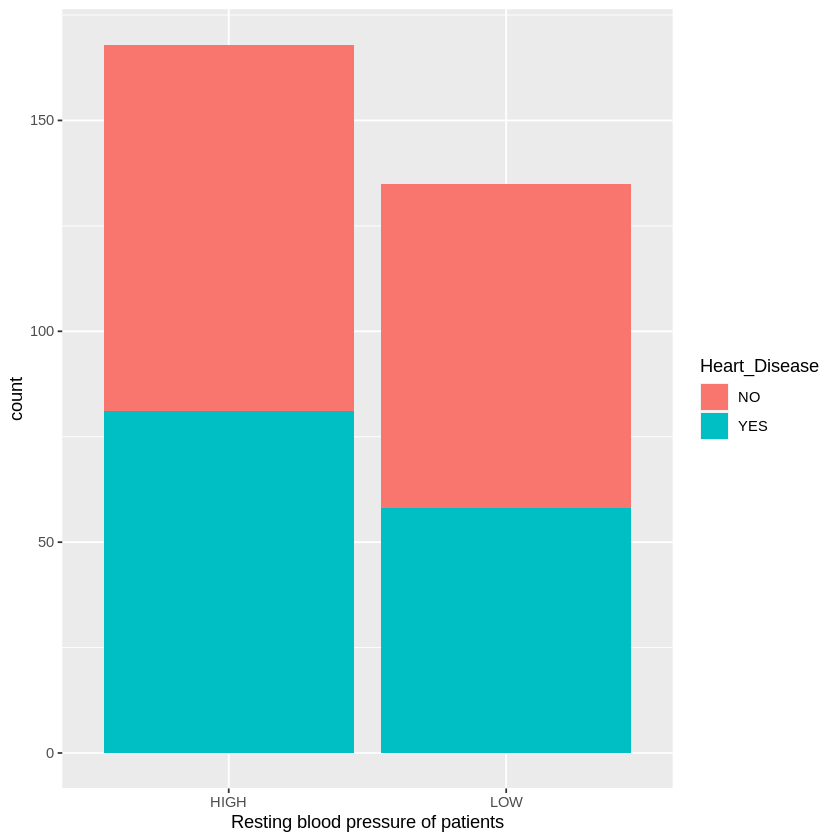

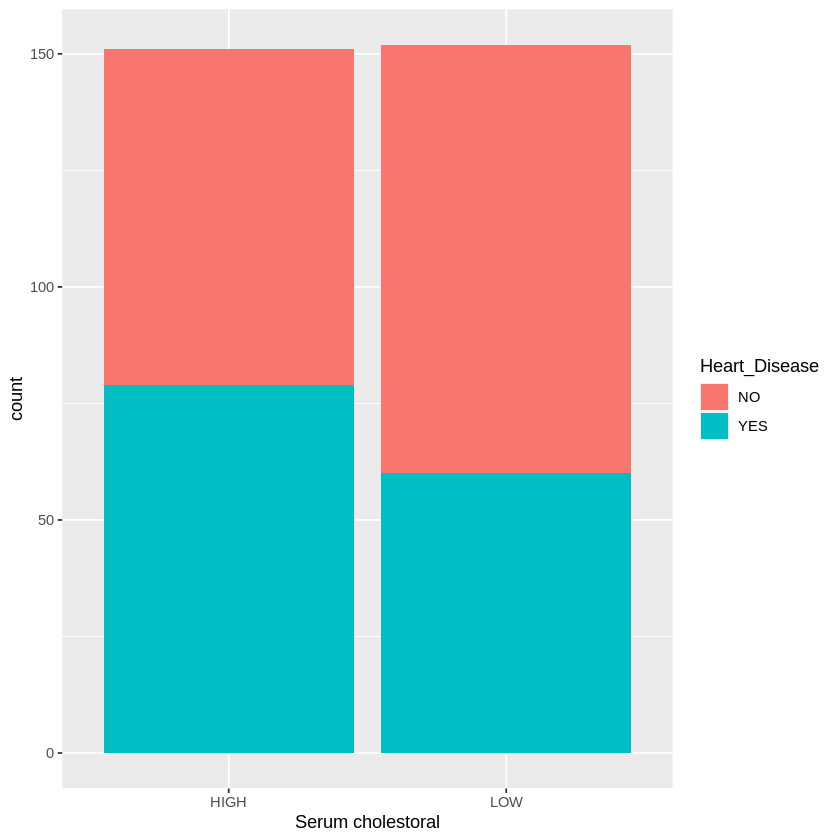

In [5]:
ggplot(heart_data, 
       aes(x = trestbps, fill = Heart_Disease)) +
  geom_bar() + 
  labs(x = "Resting blood pressure of patients")

ggplot(heart_data, 
       aes(x = chol, fill = Heart_Disease)) +
  geom_bar() + 
  labs(x = "Serum cholestoral")

From the both graph, we can rougly see that the proportion of people with heart disease is higher in both high resting blood pressure and cholesterol group compared to the corresponding lower level groups.

### Compute Estimates of the Parameter

After visaully checking the different ratio of heart disease, we have calculated sample proportions of people with heart disease in each group and created three data frame and two tables to summarize the data.

In [6]:
#Generate the percentage of two variables under a four-column combination
heart_data_n <- heart_data %>%
                      tally()%>%
                        pull()
#proportion of the four combinations of low or high resting blood pressure 
#and presence or absence of heart disease.
heart_data_prop_trestbps <-heart_data %>% 
                             group_by(trestbps, Heart_Disease)%>%
                             count() %>% 
                             mutate(p = n/heart_data_n)


#the proportion of the four combinations of the low or high cholesterol and 
#the presence or absence of heart disease.
heart_data_prop_chol <- heart_data %>% 
                          group_by(chol, Heart_Disease)%>%
                          count() %>% 
                          mutate(p = n/heart_data_n)

trest_high_yes <- heart_data_prop_trestbps %>%
                    filter(trestbps=="HIGH", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()

trest_high_no <- heart_data_prop_trestbps %>%
                    filter(trestbps=="HIGH", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()



trest_low_yes <- heart_data_prop_trestbps %>%
                    filter(trestbps=="LOW", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()

trest_low_no <- heart_data_prop_trestbps %>%
                    filter(trestbps=="LOW", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()



chol_high_yes <- heart_data_prop_chol %>%
                    filter(chol=="HIGH", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()
chol_high_no <- heart_data_prop_chol %>%
                    filter(chol=="HIGH", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()
chol_low_yes <- heart_data_prop_chol %>%
                    filter(chol=="LOW", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()
chol_low_no <- heart_data_prop_chol %>%
                    filter(chol=="LOW", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()

trest_high_n <- trest_high_yes + trest_high_no
trest_low_n <- trest_low_yes + trest_low_no
chol_high_n <- chol_high_yes + chol_high_no
chol_low_n <- chol_low_yes + chol_low_no

heart_data_prop_trestbps
heart_data_prop_chol

#Generate the proportion of patients with heart disease with or without high resting blood pressure
Trestbps <- c("HIGH","LOW")
Heart_Disease <- c("YES","YES")
proportion <- c(trest_high_yes/trest_high_n,trest_low_yes/trest_low_n)
heart_data_prop_trestbps_1 <- data.frame(Trestbps,Heart_Disease,proportion)
print(heart_data_prop_trestbps_1)
#Generate the proportion of patients with heart disease with or without high cholesterol
Chol <- c("HIGH","LOW")
proportion <- c(chol_high_yes/chol_high_n,chol_low_yes/chol_low_n)
heart_data_prop_chol_1 <- data.frame(Chol,Heart_Disease,proportion)
print(heart_data_prop_chol_1)


#the estimates after taking 1000 replicates of "shuffles" and assuming the null hypothesis is true
null_distribution <- heart_data %>% 
  specify(formula = Heart_Disease ~ trestbps, success = "YES") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("HIGH", "LOW"))

head(null_distribution)

trestbps,Heart_Disease,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,87,0.2871287
HIGH,YES,81,0.2673267
LOW,NO,77,0.2541254
LOW,YES,58,0.1914191


chol,Heart_Disease,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,72,0.2376238
HIGH,YES,79,0.2607261
LOW,NO,92,0.3036304
LOW,YES,60,0.1980198


  Trestbps Heart_Disease proportion
1     HIGH           YES  0.4821429
2      LOW           YES  0.4296296
  Chol Heart_Disease proportion
1 HIGH           YES  0.5231788
2  LOW           YES  0.3947368


replicate,stat
<int>,<dbl>
1,-0.0009259259
2,-0.0944444444
3,-0.0142857143
4,0.0257936508
5,-0.0009259259
6,-0.0543650794


<b>!!!Table Number!!! </b> shows the different proportions of people with heart diseasee of each group.</br>
Between the low and the high Trestbps groups, the higher Trestbps sample has about 12.2% higher proportion than the lower Trestbps sample. </br>
Between the low and the high Chol groups, the higher Chol sample has about 32.5% higher proportion than the lower Chol sample. This is much higher difference between the two groups than in Trestbps </br>
These non-trivial differences in the proportion of having heart disease between LOW and HIGH suggest that it would be possible to find out whether high or low resting blood pressure and high or low cholesterol make patients more likely to have heart disease.


### Two Hypothesis Tests </br>
Based on the preliminary results, we devised two hypothesis tests to estimate whether the proportions of poeple with heart diseaes is significantly higher both in high Trestbps and Chol groups compared to those of the lower gorups. </br>
As we do not have a specific reason to avoid either Type1 or Type2 error, we will use 5% significane level that is widely used in many hypothesis tests.

> #### Hypothesis Test1

> $p_{1}$ : proportion of people having heart disease with low blood pressure</br>
>$p_{2}$ : proportion of people having heart disease with high blood pressure</br>

>$H_0$ : $p_{2} - p_{1} = 0$  </br>
>$H_1$ : $p_{2} - p_{1} > 0$</br>

>#### Hypothesis Test2

>$p_{3}$ : proportion of people having heart disease with low cholesterol level</br>
>$p_{4}$ : proportion of people having heart disease with high cholesterol level

>$H_0$ : $p_{4} - p_{3} = 0$  </br>
>$H_1$ : $p_{4} - p_{3} > 0$</br>


### Theory-Based Test (Two-sample z-test)

First, We will conduct a theoy-based Hypothesis test uisng the Z-score of our sample. </br>
We will use the Z-score calculated from two independent sample. Our test statistic Z is</br>
$$Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$
where $\hat{p}_1$ and $\hat{p}_2$ are the sample proportions in two independent samples; $n$ is the sample size; and $\hat{p}$ is the pooled proportion, given by: 

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$
Since, in this case, the population distribution is clearly not Normal, we need to rely on the CLT. To use CLT, we need to check $n \hat{p} \geq 10$ and $n(1-\hat{p})\geq 10$, </br>


In [25]:
n1_tres = trest_high_yes + trest_high_no
n2_tres = trest_low_yes + trest_low_no
p1_tres = heart_data_prop_trestbps_1$proportion[1]
p2_tres = heart_data_prop_trestbps_1$proportion[2]

phat_tres = (n1_tres*p1_tres + n2_tres*p2_tres)/(n1_tres+n2_tres)
# phat_tres

n1_chol = chol_high_yes + chol_high_no
n2_chol = chol_low_yes + chol_low_no
p1_chol = heart_data_prop_chol_1$proportion[1]
p2_chol = heart_data_prop_chol_1$proportion[2]


phat_chol = (n1_chol*p1_chol + n2_chol*p2_chol)/(n1_chol+n2_chol)
phat_tres
phat_chol
phat = phat_chol

heart_data_n * phat # is this larger than 10?
heart_data_n * (1-phat) # is this larger than 10?


[1] 0.4587459

[1] 0.4587459

[1] 139

[1] 164


Since both of the phat for tres and chol are the number of high people with heart disease divided by the sample size,
the calculated phats are exacltly the same. Thus, we will use only phat value stored in the variable 'phat'. </br>
From the calculated results, we can clearly see that $n \hat{p} \geq 10$ and $n(1-\hat{p})\geq 10$ in our sample. So we can assume that our sample size is large enough, and the null model (i.e., the sampling distribution under $H_0$) of the test statistic $Z$ is approximately $N(0, 1)$.

In [26]:
z_test_tres <- tidy(
        prop.test(x = c(trest_high_yes,trest_low_yes), 
                  n = c(n1_tres,n2_tres), 
                  alternative = "greater",
                  correct = FALSE))

z_test_chol <- tidy(
        prop.test(x = c(chol_high_yes,chol_low_yes), 
                  n = c(n1_chol,n2_chol), 
                  alternative = "greater",
                  correct = FALSE))

tres_p_value_theory <- z_test_tres$p.value
chol_p_value_theory <- z_test_chol$p.value

tres_p_value_theory
chol_p_value_theory

[1] 0.1809466

[1] 0.0124351

We obtained the p-value of 0.181 from the Hypothesis Test 1 and 0.012 form the Hypothesis Test 2. </br>
Thus, we accept the null hypothesis for the Test1 and reject the null hypothesis for the Test2

### Simulation-Based Test (Using Bootstrapping)
Next, we conducted the same two hypothesis tests but using bootsrapping method. Since we are testing the independence of two variables, we use "Independence" in the null hypothesis, and 1000 replications are statistically large enough when creating the sample. Also, I chose type = "permute" to create the sample here instead of type = "bootstrap". Then, we visualized the p-value on the bootstrapping sampling distribution.



In [27]:
obs_pop_diff_trestbps <- heart_data_prop_trestbps_1$proportion[1] -
heart_data_prop_trestbps_1$proportion[2]
obs_pop_diff_chol <- heart_data_prop_chol_1$proportion[1] - heart_data_prop_chol_1$proportion[2]
obs_pop_diff_trestbps
obs_pop_diff_chol

[1] 0.05251323

[1] 0.128442

[1] 0.235

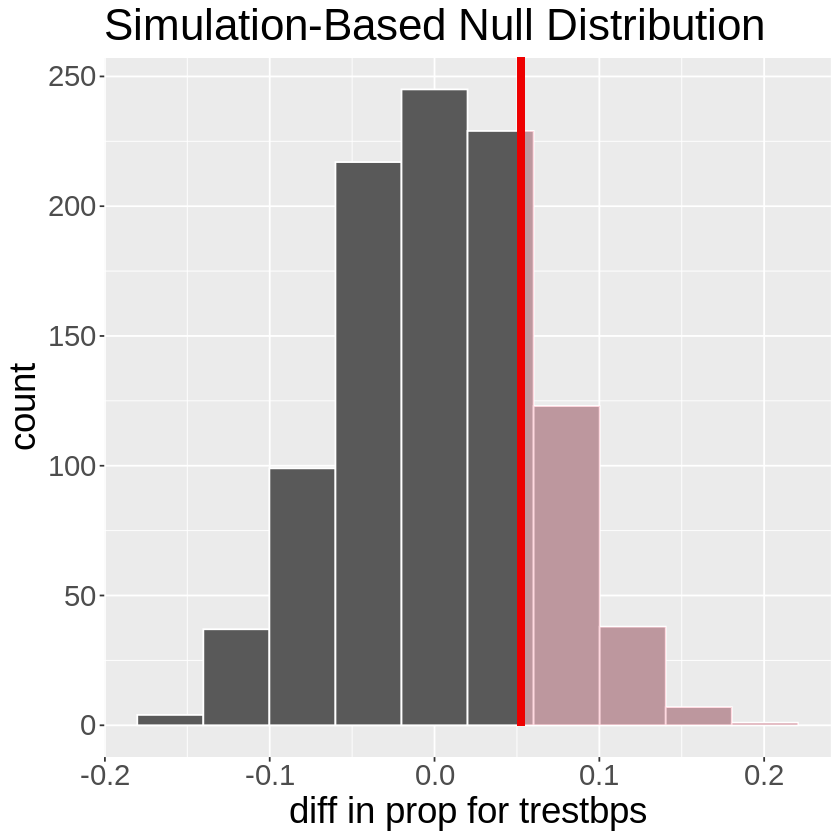

In [28]:
#the estimates after taking 1000 replicates of "shuffles" and assuming the null hypothesis is true
null_distribution_trestbps <- heart_data %>% 
    specify(formula = Heart_Disease ~ trestbps, success = "YES") %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat = "diff in props", order = c("HIGH", "LOW"))

tres_p_value_sim <- null_distribution_trestbps%>%
    get_p_value(obs_stat = obs_pop_diff_trestbps, direction = "right")%>%
    pull()
tres_p_value_sim
result_plot_trestbps <- 
    visualize(null_distribution_trestbps, bins = 10) + 
    shade_p_value(obs_stat = obs_pop_diff_trestbps, direction = "right") +
    theme(text = element_text(size = 22)) +
    xlab("diff in prop for trestbps")

result_plot_trestbps

[1] 0.02

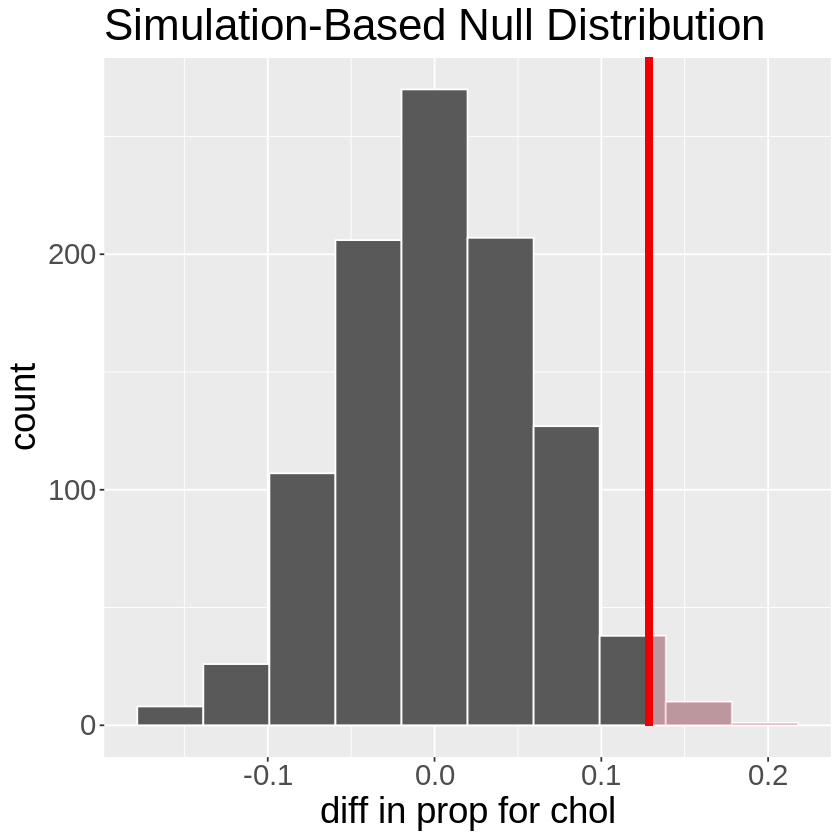

In [29]:
null_distribution_chol <- heart_data %>% 
    specify(formula = Heart_Disease ~ chol, success = "YES") %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat = "diff in props", order = c("HIGH", "LOW"))


chol_p_value_sim <- null_distribution_chol%>%
    get_p_value(obs_stat = obs_pop_diff_chol, direction = "right")%>%
    pull()
chol_p_value_sim

result_plot_chol <- 
    visualize(null_distribution_chol, bins = 10) + 
    shade_p_value(obs_stat = obs_pop_diff_chol, direction = "right") +
    theme(text = element_text(size = 22)) +
    xlab("diff in prop for chol")

result_plot_chol

We obtained the p-value of 0.217(>0.05) from the Hypothesis Test 1 and 0.017(<0.05) form the Hypothesis Test 2.</br>
Thus, as in the theory-based tests, we accept the null hypothesis for the Test1 and reject the null hypothesis for the Test2.

### Theory-Based Test vs Simulation-Based Test

In [30]:
test_comparison <- data.frame(test_method = c("Theory-Based", "Simulation-Based"),
                              tres_p_value = c(tres_p_value_theory, tres_p_value_sim),
                              chol_p_value = c(chol_p_value_theory, chol_p_value_sim))
test_comparison                              

test_method,tres_p_value,chol_p_value
<chr>,<dbl>,<dbl>
Theory-Based,0.1809466,0.0124351
Simulation-Based,0.2350000,0.0200000


Finally, we compared the results from the two different test methods. Even though we drew the same conclusion from both of the tests methods, we noticed that the two p-values of the same test were a bit different in both tests.
We reasoned that this is because of the uncertaintiy added to the theory-based test as Z-test uses the standard-error of the sample assuming that it is the standard deviation of the population.
Thus, we concluded that the p-values from the theory-based tests are more reliable in our case.

## Discussion
### Summary

### Meaning and Significance
After conducting both the bootstrapping and asymptotic method of hypothesis tests, we do not find evidence that people with high resting blood pressure have a higher chance of developing heart diseases, which is different from what we expected to find. However, it does not mean that having high blood pressure does not impact the development of heart diseases.
On the other hand, we find that people with high cholesterol levels do have a higher chance of developing heart disease, which matches what we expected to find. Although our expectations are not fully met, our findings can impact not only future studies in this area but also our daily life.
First of all, our findings provide substantial scientific evidence to the claim that suggests maintaining a low cholesterol level to lower the risk of heart disease (CDC, 2020). Also, our findings enhanced the reliability of the positive correlation between cholesterol level and heart disease, which further helped to raise awareness of the importance of keeping a healthy diet and life cycle to keep our cholesterol at a healthy level. 
### Limitation
However, due to the limitations of this project, our analysis did not regard the severity of heart disease as we solely classified patients as having heart disease or not. Also, we classified blood pressure and cholesterol level in relative terms using 50% quantile instead of medical standards. 
### Further Study
Future researchers can consider the severity level and use more professional standards to improve our research and more thoroughly study the correlations between blood pressure/cholesterol level and heart disease. Moreover, although we have found correlations between blood pressure/cholesterol level and heart disease, we cannot conclude that high blood pressure or high cholesterol level causes heart issues or not. Therefore, future research can focus on whether high blood pressure or high cholesterol level causes the development of heart issues, or if other potential factors may cause heart diseases. 


### Reference

World Health Organization(WHO). (n.d.). Cardiovascular diseases. World Health Organization. Retrieved July 26, 2022, from https://www.who.int/health-topics/cardiovascular-diseases </br>
Centers for Disease Control and Prevention(CDC). (2020, April 21). Prevent heart disease. Centers for Disease Control and Prevention. Retrieved July 26, 2022, from https://www.cdc.gov/heartdisease/prevention.htm 